<a href="https://colab.research.google.com/github/ShaunakSen/Data-Science-and-Machine-Learning/blob/master/Similarity_in_time_series_data.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Four ways to quantify synchrony between time series data

[article by Jin Hyun Cheong](https://towardsdatascience.com/four-ways-to-quantify-synchrony-between-time-series-data-b99136c4a9c9)

### 1. Pearson correlation — simple is best

The Pearson correlation measures how two continuous signals co-vary over time and indicate the linear relationship as a number between -1 (negatively correlated) to 0 (not correlated) to 1 (perfectly correlated). It is intuitive, easy to understand, and easy to interpret.

Two things to be cautious when using Pearson correlation is that:

1. outliers can skew the results of the correlation estimation

2. it assumes the data are homoscedastic such that the variance of your data is homogenous across the data range. The assumption of homoscedasticity (meaning “same variance”) is central to linear regression models.  Homoscedasticity describes a situation in which the error term (that is, the “noise” or random disturbance in the relationship between the independent variables and the dependent variable) is the same across all values of the independent variables. 


**Generally, the correlation is a snapshot measure of global synchrony. Therefore it does not provide information about directionality between the two signals such as which signal leads and which follows.**

The Pearson correlation is implemented in multiple packages including Numpy, Scipy, and Pandas. If you have null or missing values in your data, correlation function in Pandas will drop those rows before computing whereas you need to manually remove those data if using Numpy or Scipy’s implementations.

The following code loads are sample data (in the same folder), computes the Pearson correlation using Pandas and Scipy and plots the median filtered data.



In [0]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats
%matplotlib inline

In [2]:
df = pd.read_csv('./synchrony_sample.csv')

df.head()

,S1_Joy,S2_Joy
0,1.662181,0.611217
1,1.584762,0.697876
2,1.413029,1.198360
3,1.995480,0.950441
4,1.981835,0.669841


In [5]:
overall_pearson_r = df.corr().iloc[0,1]
print(f"Pandas computed Pearson r: {overall_pearson_r}")

Pandas computed Pearson r: 0.2058774513561943


In [9]:
df.rolling(window=30, center=True).median().head(20)

,S1_Joy,S2_Joy
0,NaN,NaN
1,NaN,NaN
2,NaN,NaN
3,NaN,NaN
4,NaN,NaN
5,NaN,NaN
6,NaN,NaN
7,NaN,NaN
8,NaN,NaN
9,NaN,NaN


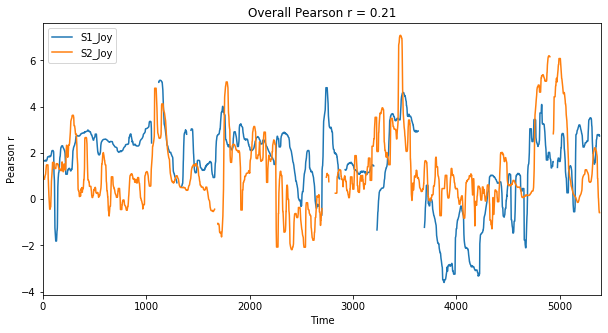

In [11]:
# Compute rolling window synchrony
f,ax=plt.subplots(figsize=(10,5))
df.rolling(window=30,center=True).median().plot(ax=ax)
ax.set(xlabel='Time',ylabel='Pearson r')
ax.set(title=f"Overall Pearson r = {np.round(overall_pearson_r,2)}");

Once again, the Overall Pearson r is a measure of global synchrony that reduces the relationship between two signals to a single value. Nonetheless there is a way to look at moment-to-moment, local synchrony, using Pearson correlation. One way to compute this is by measuring the Pearson correlation in a small portion of the signal, and repeat the process along a rolling window until the entire signal is covered. This can be somewhat subjective as it requires arbitrarily defining the window size you’d like to repeat the procedure. In the code below we use a window size of 120 frames (~4 seconds) and plot the moment-to-moment synchrony in the bottom figure.

In [13]:
# Set window size to compute moving window synchrony.
r_window_size = 120
# Interpolate missing data.
df_interpolated = df.interpolate()

df_interpolated.head()

,S1_Joy,S2_Joy
0,1.662181,0.611217
1,1.584762,0.697876
2,1.413029,1.198360
3,1.995480,0.950441
4,1.981835,0.669841


### Dynamic Time Warping — synchrony of signals varying in lengths

Dynamic time warping (DTW) is a method that computes the path between two signals that minimize the distance between the two signals. The greatest advantage of this method is that it can also deal with signals of different length. Originally devised for speech analysis (learn more in this [video](https://www.youtube.com/watch?v=_K1OsqCicBY)), DTW computes the euclidean distance at each frame across every other frames to compute the minimum path that will match the two signals. One downside is that it cannot deal with missing values so you would need to interpolate beforehand if you have missing data points.

![](https://miro.medium.com/max/304/1*LXQSbLyr_d_IkiDjiWx5nA.jpeg)



In [14]:
!pip install dtw

  Created wheel for dtw: filename=dtw-1.4.0-cp36-none-any.whl size=5316 sha256=2295f17e31a1e8fd30c41f8cc4c4988d3b958600932a67bdd305349a7266a3d2
  Stored in directory: /root/.cache/pip/wheels/8c/8b/7a/947d67b53cd54948890a173527b0470ef56998812fc9d0a803
Successfully built dtw


In [16]:
from dtw import dtw, accelerated_dtw

d1 = df['S1_Joy'].interpolate().values
d2 = df['S2_Joy'].interpolate().values

print (d1.shape, d2.shape)

(5400,) (5400,)


In [0]:
min_dist, cost_matrix, accumulated_cost_matrix, wrap_path = accelerated_dtw(x=d1, y=d2, dist='euclidean')


In [31]:
print('Min dist:', min_dist)

print (cost_matrix.shape, accumulated_cost_matrix.shape)

# wrap path is of the form: ([x1,x2,x3...xn], [y1,y2,y3,...yn])

print (wrap_path)

Min dist: 3523.7341926616696
(5400, 5400) (5400, 5400)
(array([   0,    1,    2, ..., 5399, 5399, 5399]), array([   0,    1,    2, ..., 5397, 5398, 5399]))


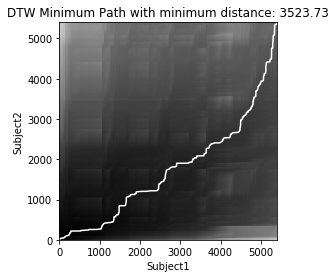

In [32]:
plt.imshow(accumulated_cost_matrix.T, origin='lower', cmap='gray', interpolation='nearest')
plt.plot(wrap_path[0], wrap_path[1], 'w')
plt.xlabel('Subject1')
plt.ylabel('Subject2')
plt.title(f'DTW Minimum Path with minimum distance: {np.round(min_dist,2)}')
plt.show()

Here we can see the minimum path shown in the white convex line. In other words, earlier Subject2 data is matched with synchrony of later Subject1 data. The minimum path cost is d=3523 which can be compared with that of other signals.


(5400, 5400) (5400, 5400)
(array([   0,    1,    2, ..., 5397, 5398, 5399]), array([   0,    1,    2, ..., 5397, 5398, 5399]))


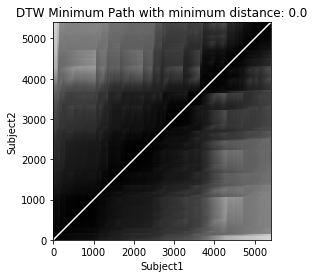

In [33]:
### whats the dtw bw two identical signals?

min_dist, cost_matrix, accumulated_cost_matrix, wrap_path = accelerated_dtw(x=d1, y=d1, dist='euclidean')
print (cost_matrix.shape, accumulated_cost_matrix.shape)
print (wrap_path)

plt.imshow(accumulated_cost_matrix.T, origin='lower', cmap='gray', interpolation='nearest')
plt.plot(wrap_path[0], wrap_path[1], 'w')
plt.xlabel('Subject1')
plt.ylabel('Subject2')
plt.title(f'DTW Minimum Path with minimum distance: {np.round(min_dist,2)}')
plt.show()

## DTW computation using tslearn

[link](https://tslearn.readthedocs.io/en/latest/auto_examples/plot_dtw.html#sphx-glr-auto-examples-plot-dtw-py)

In [26]:
!pip install tslearn

     |████████████████████████████████| 532kB 9.0MB/s 
  Created wheel for tslearn: filename=tslearn-0.2.5-cp36-cp36m-linux_x86_64.whl size=816775 sha256=75f141267c3aeb89476944d27041f8815606269d794029a9174194f894053653
  Stored in directory: /root/.cache/pip/wheels/1d/6a/f7/145f874cbaebf801a5d89b71197585db9b1ddc72d666236cc3
Successfully built tslearn


In [0]:
from tslearn.generators import random_walks
from tslearn.preprocessing import TimeSeriesScalerMeanVariance
from tslearn import metrics

np.random.seed(0)
n_ts, sz, d = 2, 100, 1 # n_ts:Number of time series sz:Length of time series (number of time instants) d: Dimensionality of time series
dataset = random_walks(n_ts=n_ts, sz=sz, d=d)

In [48]:
print (dataset.shape) # 2 time series data of shape (100, 1)

(2, 100, 1)


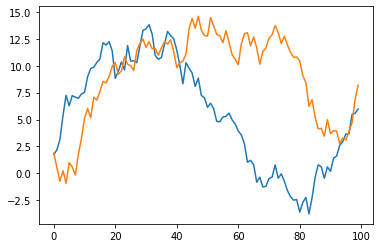

In [49]:
plt.plot(np.arange(sz), dataset[0,:,0])
plt.plot(np.arange(sz), dataset[1,:,0])

Scale the dataset using MeanVariance scaler

In [0]:
# scales the time series st the mean is mu and std dev is std
scaler = TimeSeriesScalerMeanVariance(mu=0., std=1.)

dataset_scaled = scaler.fit_transform(dataset)

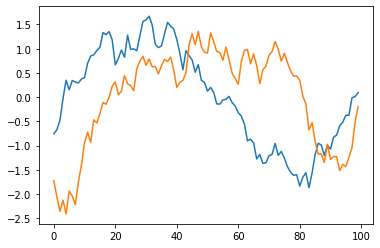

In [51]:
plt.plot(np.arange(sz), dataset_scaled[0,:,0])
plt.plot(np.arange(sz), dataset_scaled[1,:,0])

What if the 2 datsets vary considerably in terms of magnitude. Does mean-variance scaling bring them to the same level?

In [0]:
### create a separate copy of the original dataset to experiment on

dataset_modified = np.copy(dataset)

## amplify value of 1st data
dataset_modified[0,:,0] = np.multiply(dataset_modified[0,:,0], 3)


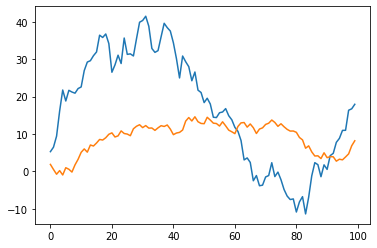

In [54]:
plt.plot(np.arange(sz), dataset_modified[0,:,0])
plt.plot(np.arange(sz), dataset_modified[1,:,0])

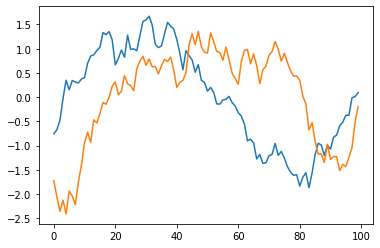

In [55]:
### standardize this new dataset
scaler = TimeSeriesScalerMeanVariance(mu=0., std=1.)

dataset_modified_scaled = scaler.fit_transform(dataset_modified)

plt.plot(np.arange(sz), dataset_modified_scaled[0,:,0])
plt.plot(np.arange(sz), dataset_modified_scaled[1,:,0])

In [57]:
dataset_scaled[0,:,0]

array([-0.75643578, -0.67590556, -0.47893803, -0.02796624,  0.34787316,
        0.15119946,  0.34240137,  0.31194128,  0.29116885,  0.37380034,
        0.40278859,  0.69545596,  0.8486121 ,  0.87309876,  0.96242466,
        1.02957543,  1.33025353,  1.28896615,  1.35196992,  1.18008619,
        0.66630607,  0.79784449,  0.9718092 ,  0.82245113,  1.27923117,
        0.98654525,  0.99575399,  0.95808391,  1.26655027,  1.56225349,
        1.59343611,  1.66953997,  1.49087625,  1.09224801,  1.02223193,
        1.0536966 ,  1.30128822,  1.54326289,  1.46531475,  1.40447739,
        1.19345984,  0.90768628,  0.56430548,  0.95689208,  0.8543264 ,
        0.7661655 ,  0.51404489,  0.67051206,  0.34572086,  0.30290764,
        0.12269818,  0.20056093,  0.09776321, -0.13983482, -0.14550639,
       -0.05930612, -0.04591977,  0.01495162, -0.11270344, -0.18570381,
       -0.32103408, -0.39339288, -0.55703567, -0.9044439 , -0.86873752,
       -0.94959451, -1.27766613, -1.18453284, -1.36712341, -1.35

In [58]:
dataset_modified_scaled[0,:,0]

array([-0.75643578, -0.67590556, -0.47893803, -0.02796624,  0.34787316,
        0.15119946,  0.34240137,  0.31194128,  0.29116885,  0.37380034,
        0.40278859,  0.69545596,  0.8486121 ,  0.87309876,  0.96242466,
        1.02957543,  1.33025353,  1.28896615,  1.35196992,  1.18008619,
        0.66630607,  0.79784449,  0.9718092 ,  0.82245113,  1.27923117,
        0.98654525,  0.99575399,  0.95808391,  1.26655027,  1.56225349,
        1.59343611,  1.66953997,  1.49087625,  1.09224801,  1.02223193,
        1.0536966 ,  1.30128822,  1.54326289,  1.46531475,  1.40447739,
        1.19345984,  0.90768628,  0.56430548,  0.95689208,  0.8543264 ,
        0.7661655 ,  0.51404489,  0.67051206,  0.34572086,  0.30290764,
        0.12269818,  0.20056093,  0.09776321, -0.13983482, -0.14550639,
       -0.05930612, -0.04591977,  0.01495162, -0.11270344, -0.18570381,
       -0.32103408, -0.39339288, -0.55703567, -0.9044439 , -0.86873752,
       -0.94959451, -1.27766613, -1.18453284, -1.36712341, -1.35

In [64]:
print (dataset_scaled[0,:,0].shape, dataset_modified_scaled[0,:,0].shape)

print(dataset_scaled[0,:,0].sum(), dataset_modified_scaled[0,:,0].sum())

np.isclose(dataset_scaled[0,:,0], dataset_modified_scaled[0,:,0])

(100,) (100,)
2.3717139363554907e-14 1.021405182655144e-14


array([ True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True])

The results look similar - MeanVariance scaling is good

Now we apply the DTW algorithm 

In [0]:
### compute DTW
path, sim = metrics.dtw_path(dataset_scaled[0], dataset_scaled[1])

In [72]:
print (dataset_scaled[0].shape)
print (len(path))
print (path[:10])
print (sim)

(100, 1)
154
[(0, 0), (0, 1), (0, 2), (0, 3), (0, 4), (0, 5), (0, 6), (0, 7), (0, 8), (0, 9)]
4.485257265545512


In [0]:
matrix_path = np.zeros((sz, sz), dtype=np.int)

for i, j in path:
  matrix_path[i, j] = 1
  

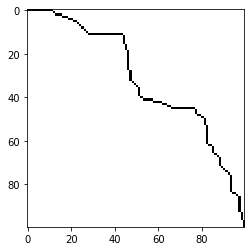

In [78]:
plt.imshow(matrix_path, cmap='gray_r')